## [Chapter 5](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

import daft
import theano.tensor as tt
import pymc3 as pm

np.random.seed(865)

'Done'

/home/alex/.envs/think-series/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'Done'

## Loss Functions Overview

- Loss functions quantify the difference between true and estimated parameters: $L(\theta, \hat{\theta}) = f(\theta, \hat{\theta})$
- Often important to focus on the outcomes of the parameter estimation, moreso than the parameters themselves. Example: weather forecasters want to prevent false negatives when predicting rain, so their loss function can be weighted to accomodate this preference.
- In practice, the true parameter, $\theta$, is unknown; we consider it to be a random variable with prior and posterior distributions. To compute an expected loss for an estimated parameter, we can compare it to values drawn from the posterior.
- I find the "Loss functions in the real world" section unnecessarily complicated... hopefully the examples will be better.

## Example: Optimizing the Showcase on The Price is Right

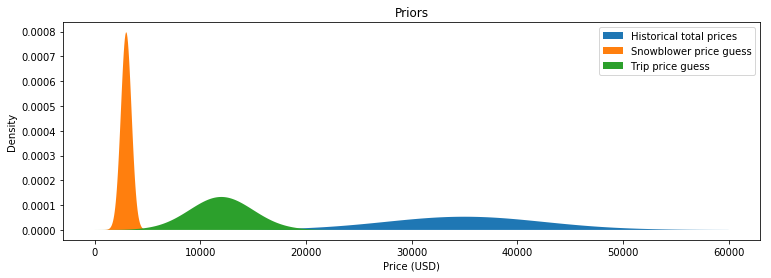

In [2]:
plt.figure(figsize=(12.5, 4))

rv = stats.norm(35000, 7500)
X = np.linspace(0, 60000, 200)
P = rv.pdf(X)
plt.fill_between(X, 0, P, label='Historical total prices')

rv = stats.norm(3000, 500)
X = np.linspace(0, 10000, 200)
P = rv.pdf(X)
plt.fill_between(X, 0, P, label='Snowblower price guess')

rv = stats.norm(12000, 3000)
X = np.linspace(0, 25000, 200)
P = rv.pdf(X)
plt.fill_between(X, 0, P, label='Trip price guess')

plt.title('Priors')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.legend()
plt.show()

The book fails to explain the model in sufficient detail, particularly the role of the `Potential` class in the model, which is used in lieu of real observations and effectively "moves" the posterior to the left. There are some additional explanations here:

1. [pymc3 docs](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class)
2. [stats stack exchange](https://stats.stackexchange.com/questions/251280/what-is-pm-potential-in-pymc3)

He does mention that a later model will incorporate data.

In [3]:
with pm.Model() as pir_model:
    
    price_true = pm.Normal('true_price', mu=35e3, sd=75e2)
    
    prize_1 = pm.Normal('prize_1', mu=3e3, sd=5e2)
    prize_2 = pm.Normal('prize_2', mu=12e3, sd=3e3)
    
    price_pred = prize_1 + prize_2
    
    # TODO: gain intuition for the following two lines that are used 
    # to circumvent including observed values.
    logp = pm.Normal.dist(mu=price_pred, sd=3e3).logp(price_true)
    error = pm.Potential('error', logp)
    
    pir_trace = pm.sample(50000, step=pm.Metropolis())
    pir_burned_trace = pir_trace[10000:]
    
'Done'

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [prize_2]
>Metropolis: [prize_1]
>Metropolis: [true_price]
 24%|██▍       | 12284/50500 [00:08<00:27, 1411.47it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '32480' (I am process '32481')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/alex/.theano/compiledir_Linux-4.8--generic-x86_64-with-LinuxMint-18.2-sonya-x86_64-3.5.2-64/lock_dir
100%|██████████| 50500/50500 [00:34<00:00, 1465.36it/s]
The number of effective samples is smaller than 10% for some parameters.


'Done'

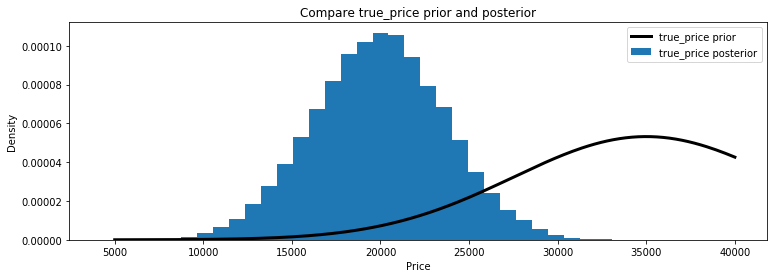

In [4]:
plt.figure(figsize=(12.5, 4))

X = np.linspace(5000, 40000, 200)
rv = stats.norm(35000, 7500)
P = rv.pdf(X)

plt.plot(X, P, lw=3, color='k', label='true_price prior')
plt.hist(pir_burned_trace['true_price'], bins=35, density=True, histtype='stepfilled', label='true_price posterior')

plt.title('Compare true_price prior and posterior')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Incorporate a loss function that models the game's logic and incentives. Plot the expected loss across various guesses and risk values.

Following the notation from the book, $\theta$ is the posterior sample of true prices, $\hat{\theta}$ is a *single* guess at the prices, and the expected loss $E_{\theta}[L(\theta, \hat{\theta}]$ is defined:

$E_{\theta}[L(\theta, \hat{\theta}] \\
= E_{\text{posterior(true_price)}}[L(\text{posterior(true_price)}, \text{guess})] \\
= \frac{1}{|\theta|} \sum_i^{|\theta|} l(\theta_i, \hat{\theta}) $

In words, the expected loss for a single guess is the average loss of that guess against all posterior samples of the true price.

This is slightly complicated below by the fact that we evaluate losses for various "risks".

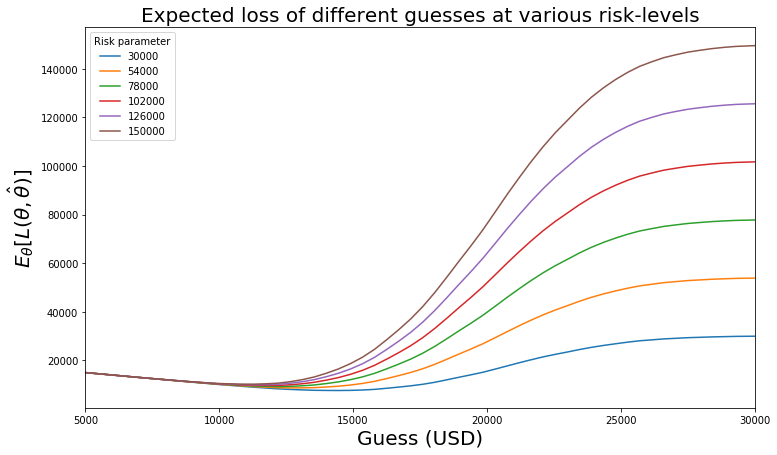

In [5]:
def showdown_loss(guess, true_price_post, risk):
    """Vectorized price is right showdown loss function.
    
    # Arguments:
        guess: a float guess for the showcase.
        true_price_pst: a numpy vector of samples from the posterior of the true price.
        risk: the loss for over-guessing the price.
    
    # Returns:
        loss: a numpy vector of loss values, one for every posterior sample. This can then
            be averaged to get the expected loss.
    
    """
    loss = np.zeros_like(true_price_post)                # Loss value for every posterior sample, start as all zeros.
    ix_over = guess > true_price_post                    # Indices where guess is over and under the true price sample.
    ix_under = ~ ix_over
    ix_bonus = [true_price_post - guess <= 250]          # Indices where guess is within 250 under the true price sample.
    loss[ix_under] = true_price_post[ix_under] - guess   # Populate loss values for under-guesses.
    loss[ix_bonus] = -2 * true_price_post[ix_bonus]      # Populate loss values for bonus-guesses.
    loss[ix_over] = risk                                 # Populate loss values for over-guesses.
    return loss                                          # Return vector of losses, one per posterior sample.
                                                         # This can be averaged to get the expected loss.

guesses = np.linspace(5000, 50000, 101)
risks = np.linspace(30000, 150000, 6)

plt.figure(figsize=(12, 7))

for risk in risks:

    # Get the expected (mean) loss for each guess with this risk value.
    expected_losses = [showdown_loss(guess, pir_burned_trace['true_price'], risk).mean()
                       for guess in guesses]
    
    plt.plot(guesses, expected_losses, label='%d' % risk)
    
plt.title("Expected loss of different guesses at various risk-levels", size=20)
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("Guess (USD)", size=20)
plt.ylabel('$E_{θ}[L(θ, \hat{θ})]$', size=20)
plt.xlim(5000, 30000)
plt.show()

Now we can optimize for the *Bayes Action*, which is the guess that minimizes the expected loss:

$ \text{arg} \min_{\hat{\theta}} \;\;E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $

Finding the Bayes action is equivalent to finding parameters that optimize an arbitrary performance measure. In this case it is the showdown loss function with respect to a posterior sample of true prices and a single risk value.

The plot shows, intuitively, that lower risks allow for higher optimal guesses.

Minimum at risk 30000 = 14534.94
Minimum at risk 54000 = 12872.42
Minimum at risk 78000 = 12168.57
Minimum at risk 102000 = 11999.65
Minimum at risk 126000 = 11209.68
Minimum at risk 150000 = 11053.62


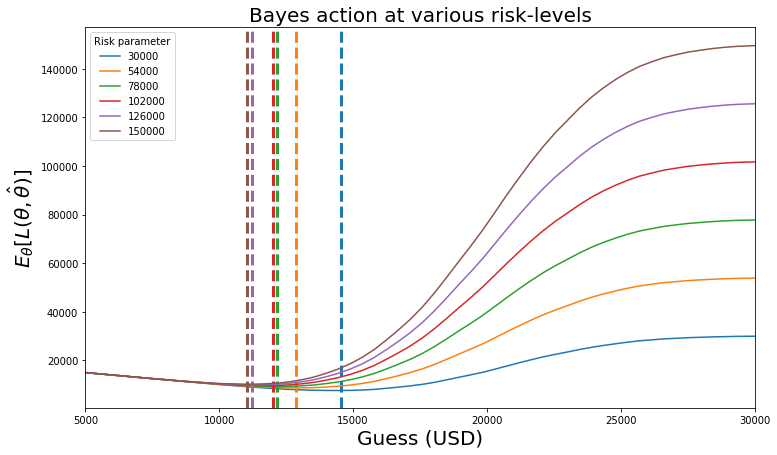

In [6]:
import scipy.optimize as sop

plt.figure(figsize=(12, 7))

for risk in risks:

    # Get the expected (mean) loss for each guess with this risk value.
    expected_losses = [showdown_loss(guess, pir_burned_trace['true_price'], risk).mean()
                       for guess in guesses]

    func = lambda x: showdown_loss(x, pir_burned_trace['true_price'], risk).mean()
    x0 = guesses[np.argmin(expected_losses)]
    min_guess = sop.fmin(func, x0, disp=False)[0]
    
    print('Minimum at risk %d = %.2lf' % (risk, min_guess))
    
    p = plt.plot(guesses, expected_losses, label='%d' % risk)
    plt.axvline(min_guess, ls='--', lw=3, c=p[0].get_color())
    
plt.title("Bayes action at various risk-levels", size=20)
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("Guess (USD)", size=20)
plt.ylabel('$E_{θ}[L(θ, \hat{θ})]$', size=20)
plt.xlim(5000, 30000)
plt.show()